# Tutorial 1: SpaCon for mouse 3D spatial transcriptome and structural connectivity

This tutorial demonstrates how to integrate whole‑brain spatial transcriptomics data and structural connectivity data in mouse using SpaCon. The spatial transcriptomics data used here is the MERFISH dataset from the study published in *Nature*: [Molecularly defined and spatially resolved cell atlas of the whole mouse brain](https://www.nature.com/articles/s41586-023-06808-9). The structural connectivity data are sourced from the [Allen Mouse Brain Connectivity Atlas](https://connectivity.brain-map.org/).

We have co‑registered both datasets to the same resolution. The processed data for this tutorial can be downloaded from this [Google Drive link](https://drive.google.com/drive/folders/1lQQQVjXt8lvciuKq_Jkp4LGsR_EQXFAi?usp=sharing).

> **Note:** If you want to use your own data, please make sure that your transcriptomics and connectivity matrices are paired spot‑by‑spot (i.e., transcriptomics as a spot × gene matrix and connectivity as a spot × spot matrix).


In [1]:
import spacon
from spacon.utils import build_spatial_graph, build_connection_graph, neighbor_sample, model_train, model_eval, clustering, plot_all_results

from spacon.model import SpaCon
import datetime
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

import torch
import numpy as np
import pickle
import random

import warnings
warnings.filterwarnings("ignore")

mus = 'mouse_1'
if mus == 'mouse_1':  # coronal
    plot_x, plot_y = 'z', 'y'
    figsize = (5,5)
elif mus == 'mouse_3':   # sagittal
    plot_x, plot_y = 'x', 'y'
    figsize = (11,5)

cluster_color=['#537eb7','#83ab8e','#ece399','#405993','#cc7f73','#d69971','#df5734','#6c408e','#9a70a8','#d4c2db','#53738c','#a25087','#a78982','#a9c2cb','#92699e','#4b6aa8','#3ca0cf','#c376a7','#ad98c3','#408444','#b95055','#d5bb72',
               '#bc9a7f','#e0cfda','#d8a0c0','#e6b884','#b05545','#d69a55','#64a776','#cbdaa9','#efd2c9','#da6f6d','#ebb1a4','#a44e89','#8c564b','#b85292','#6d6fa0','#8d689d','#c8c7e1','#d25774','#c49abc','#a5a9b0','#927c9a','#9f8d89', 
               '#72567a','#63a3b8','#c4daec','#61bada','#b7deea','#e29eaf','#4490c4','#e6e2a3','#de8b36','#c4612f','#ad98c3','#76a2be','#cea5c7','#c6adb0','#9d3b62','#2d3462', "#ff420e", "#ffbb00"]

def set_seed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

**Data preprocessing**

**Load spatial transcriptomics data**

If there are too many genes (for example, more than 5,000), we recommend first screening for highly variable genes using the following method:

```
n_top_genes = 3000
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_top_genes)
adata = adata[:, adata.var.highly_variable]
```

In [2]:
adata = sc.read_h5ad(f'./data/{mus}/adata_merge.h5ad')
print('raw adata shape:', adata.shape)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

raw adata shape: (250535, 1122)


AnnData object with n_obs × n_vars = 250535 × 1122
    obs: 'x_section_mean', 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id'
    uns: 'log1p'

**Build spatial graph**

The `build_spatial_graph` function constructs a spatial graph using the three-dimensional spatial coordinates of the spatial transcriptome. The main parameters include:

- `adata`: Spatial transcriptomics data must include the three-dimensional coordinates for each spot (i.e., the slice number and the two-dimensional coordinates within that slice).
- `section_order`: A slice order list where the sequence represents the original arrangement of each slice within the brain. While the slices can be oriented differently, their relative order must be strictly maintained.
- `rad_cutoff`: Neighborhood radius, each spot will have edges added to all other spots within its neighborhood radius.
- `rad_cutoff_Zaxis`: Inter-slice neighborhood radius, each spot will have edges added to spots in adjacent slices that are within this radius.
- `sec_x`: The column name in `adata.obs` that stores the x-coordinate of each spot within its slice.
- `sec_y`: The column name in `adata.obs` that stores the y-coordinate of each spot within its slice.
- `key_section`: Column name in `adata.obs` that stores the slice number (where different numbers indicate different slices).

In [3]:
# build the section list
section_order = np.unique(adata.obs['section']).tolist()
# calculate the spatial graph for the adata
ST_graph_data, st_adj = build_spatial_graph(adata=adata, rad_cutoff=0.7, rad_cutoff_Zaxis=1.0,
                                            sec_x='z', sec_y='y', key_section='section',
                                            section_order=section_order)
ST_graph_data

100%|██████████| 128/128 [00:54<00:00,  2.35it/s]


Data(x=[250535, 1122], edge_index=[2, 1681795])

**Load connectivity data and build connection graph**

The `build_connection_graph` function uses connection information to construct a three-dimensional connection graph. The main parameters include:

- `nt_adj`: An n x n two-dimensional matrix, where n is the number of spots in the spatial transcriptomics data, representing the connection strength between spots.
- `threshold`: Filtering threshold, connection strengths below this value will be set to zero.

In [4]:
# with open(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/ST/zxw/{mus}/PyG_Data_xy0.7_z1.0.pkl', 'rb') as f:
#     ST_graph_data = pickle.load(f)
# st_adj = load_npz(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/ST/zxw/{mus}/zxw_adj.npz')
# nt_adj = np.load('/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/mouse_1/zxw_adj.npy')
# NT_graph_data = build_connection_graph(adata, nt_adj, threshold=0.001)

eps = 0.001
proportion_after = 0.0211
with open(f'/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/{mus}/PyG_Data_eps{eps}_{proportion_after}.pkl', 'rb') as f:
    NT_graph_data = pickle.load(f)
    
NT_graph_data

Data(x=[250535, 1122], edge_index=[2, 1324207857])

**Neighbor-based subgraph sampling**

The `neighbor_sample` function performs subgraph sampling from the input spatial graph and connection graph. Its main parameters include:

- `batch_size`: The batch size for model training.
- `train_num_neighbors`: The number of neighbors to sample for each node in each iteration. This parameter is used by the data loader during the model training process.
- `eval_num_neighbors`: The number of neighbors to sample for each node in each iteration. This parameter is used by the data loader during the model evaluation process. If an entry is set to -1, all neighbors will be included.(default:`[-1]`)

The function returns three data loaders: `train_loader`, `evaluate_loader_con`, and `evaluate_loader_spa`. The `train_loader` is used during the **model training process**. Meanwhile, `evaluate_loader_con` and `evaluate_loader_spa` are used for **model evaluation** on the **connection graph** and **spatial graph**, respectively.

In [5]:
train_loader, evaluate_loader_con, evaluate_loader_spa = neighbor_sample(NT_graph_data, ST_graph_data, batch_size=64, train_num_neighbors=[20, 10, 10], eval_num_neighbors=[-1], num_workers=4)

**Model training**

In [6]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# hyper-parameters
num_epoch = 4
lr = 0.0001
weight_decay = 1e-4
hidden_dims = [adata.X.shape[1]] + [256, 64, 16]    
# model
# fusion_method indicates the feature fusion method of the middle layer, you can choose 'add' or 'concat'
model = SpaCon(hidden_dims=hidden_dims, fusion_method='concat').to(device)
# if model_save_path=None, the model will not be saved
results_save_path = f"./results/{mus}/{str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))}/"
os.makedirs(results_save_path, exist_ok=True)

model = model_train(num_epoch, lr, weight_decay, model, train_loader, st_adj, model_save_path=results_save_path, device=device)

epoch:1|4


100%|██████████| 3915/3915 [06:12<00:00, 10.50it/s]


epoch:2|4


100%|██████████| 3915/3915 [06:04<00:00, 10.75it/s]


epoch:3|4


100%|██████████| 3915/3915 [05:58<00:00, 10.91it/s]


epoch:4|4


100%|██████████| 3915/3915 [06:05<00:00, 10.71it/s]



Training completed! The model parameters have been saved to ./results/mouse_1/2025_07_23_20_37_12/model_params.pth


**Model evaluation**

The features obtained after model dimensionality reduction, named `feature_spa` and `feature_con`, are stored in the returned `adata.obsm`. These features can be used for subsequent cluster analysis.

In [7]:
adata = model_eval(model, adata, NT_graph_data, ST_graph_data, evaluate_loader_con, evaluate_loader_spa, st_adj, layer_eval=True, device=device)

Evaluating: 100%|██████████| 751605/751605 [00:45<00:00, 16534.10it/s]

The results have been saved in adata.obsm
AnnData object with n_obs × n_vars = 250535 × 1122
    obs: 'x_section_mean', 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id'
    uns: 'log1p'
    obsm: 'feature_spa', 'feature_con'


**Clustering**

The `clustering` function performs clustering using the louvain algorithm, with the following key parameters:

* `adata`: The AnnData object obtained previously, which contains the clustering features (`feature_spa`, `feature_con`).
* `alpha`: This parameter adjusts the contribution of local spatial information versus global connection information in the clustering results.
    * When `alpha = 1`, the clustering will incorporate more global information.
    * When `alpha = 0`, the clustering will focus more on local information.
    You can set different `alpha` values based on your downstream tasks.
* `adata_save_path`: The path where the results will be saved.
* `cluster_resolution`: The clustering resolution used during the louvain clustering process.

The returned `path` indicates where the clustering results are saved.

---

The `plot_all_results` function is used to visualize the clustering outcomes. It plots the clustering results for all slices collectively, and also generates individual plots for each cluster category. Its key parameters are:

* `adata`: The AnnData object that contains the clustering results, specifically in `adata.obs['clusters']`.
* `path`: The directory where the generated plots will be saved.
* `figsize`: The dimensions for the output plots.
* `plot_x`: The x-coordinate of each spot within its respective slice for plotting.
* `plot_y`: The y-coordinate of each spot within its respective slice for plotting.

In [9]:
def clustering(adata, alpha, adata_save_path, cluster_resolution=0.75):
    import copy
    adata = copy.deepcopy(adata)
    from sklearn.preprocessing import StandardScaler
    scaler_standard = StandardScaler()
    f_con = scaler_standard.fit_transform(adata.obsm['feature_con'])
    f_spa = scaler_standard.fit_transform(adata.obsm['feature_spa'])
    f_alp = (np.exp(-4 * alpha) - 1) / (np.exp(-4) - 1)
    f_add = f_alp*f_con + (1-f_alp)*f_spa
    adata.obsm['feature_add'] = f_add

    sc.pp.neighbors(adata, use_rep='feature_add', n_neighbors=40)
    sc.tl.umap(adata)


    path = adata_save_path + f'feature_add_weight{alpha}/Clusters_res{cluster_resolution}/'
    os.makedirs(path, exist_ok=True)

    sc.tl.louvain(adata,
                resolution=cluster_resolution, 
                key_added="clusters")
    sc.pl.umap(adata,color='clusters', show=False)
    plt.tight_layout()
    plt.savefig(path+f'cluster_umap_res{cluster_resolution}.png')
    adata.write_h5ad(path+'adata_cluster.h5ad')

    print(f'The clustering results have been saved in {path}')
    print(adata)

    return adata, path

**alpha = 1**

The clustering results have been saved in ./results/mouse_1/2025_07_23_20_37_12/feature_add_weight1/Clusters_res0.75/
AnnData object with n_obs × n_vars = 250535 × 1122
    obs: 'x_section_mean', 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id', 'clusters'
    uns: 'log1p', 'neighbors', 'umap', 'clusters', 'clusters_colors'
    obsm: 'feature_spa', 'feature_con', 'feature_add', 'X_umap'
    obsp: 'distances', 'connectivities'


100%|██████████| 59/59 [03:53<00:00,  3.95s/it]


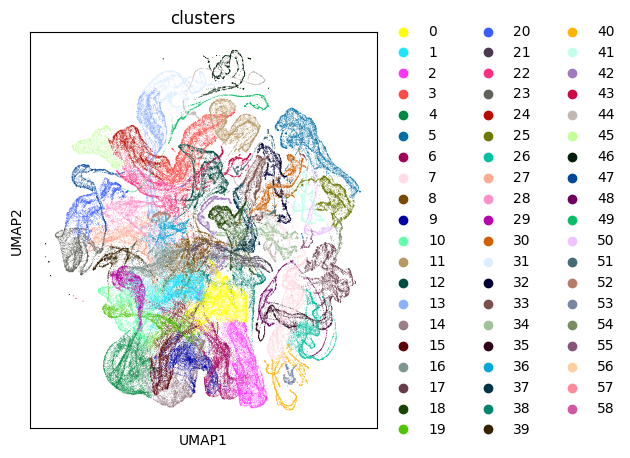

In [10]:
adata_alpha1, path = clustering(adata, alpha=1, adata_save_path=results_save_path, cluster_resolution=0.75)

plot_all_results(adata_alpha1, path, figsize, plot_x, plot_y)

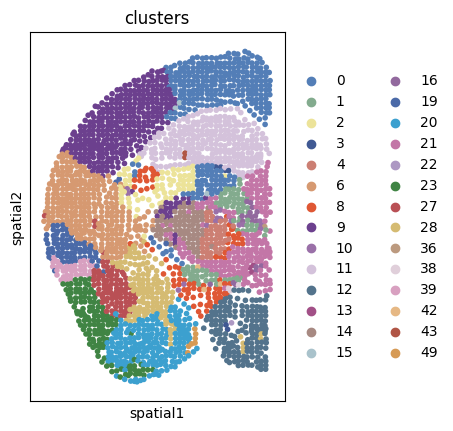

In [11]:
# 2D result plot
adata_alpha1.obsm['spatial'] = adata_alpha1.obs[['z', 'y']].values
adata_alpha1.obs.index = adata_alpha1.obs.index.astype(str)
adata_s = adata_alpha1[adata_alpha1.obs['section'] == 'Zhuang-ABCA-1.081']
adata_s = adata_s[adata_s.obs['z'] < 56]   # Removal of part of the right brain
sc.pl.spatial(adata_s, color='clusters', spot_size=1.25, show=True, palette=cluster_color)

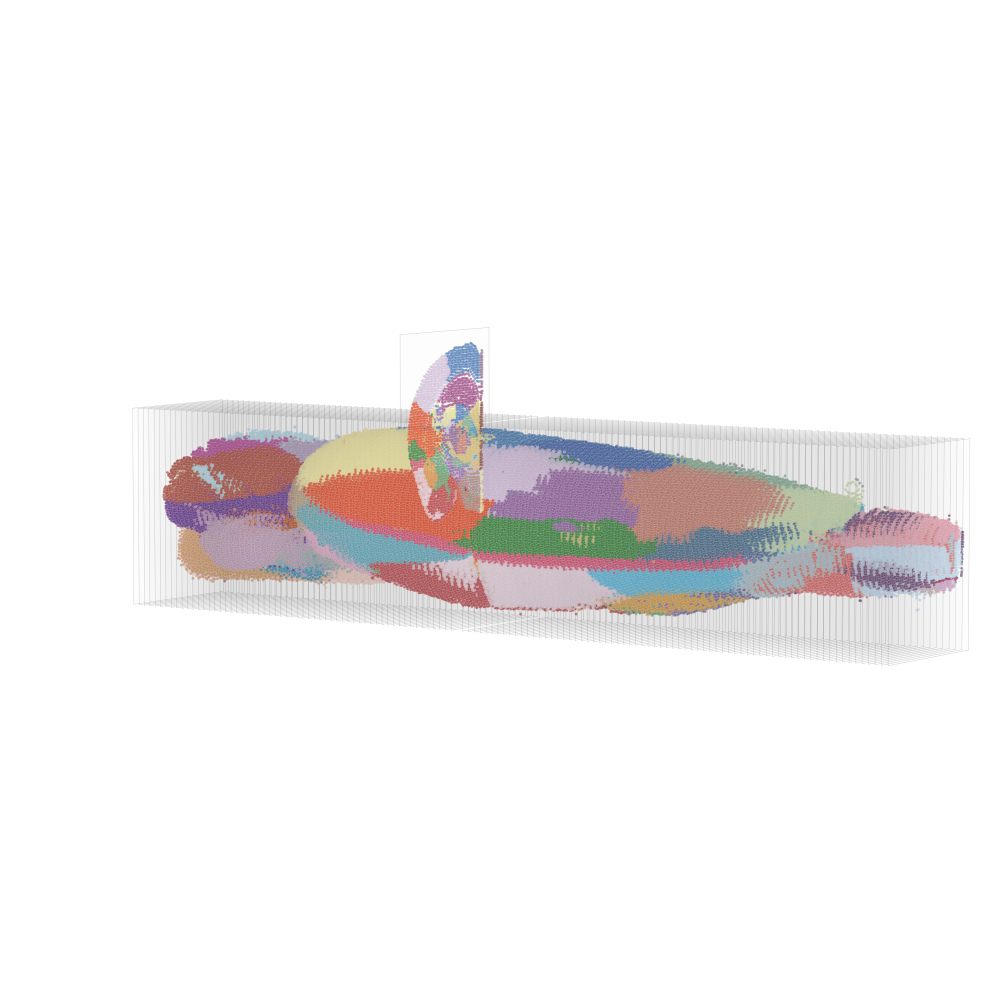

In [41]:
# 3D result plot
from spacon.utils import result_plot_3D

result_plot_3D(adata_alpha1, highlight_section='Zhuang-ABCA-1.081', cluster_color=cluster_color)

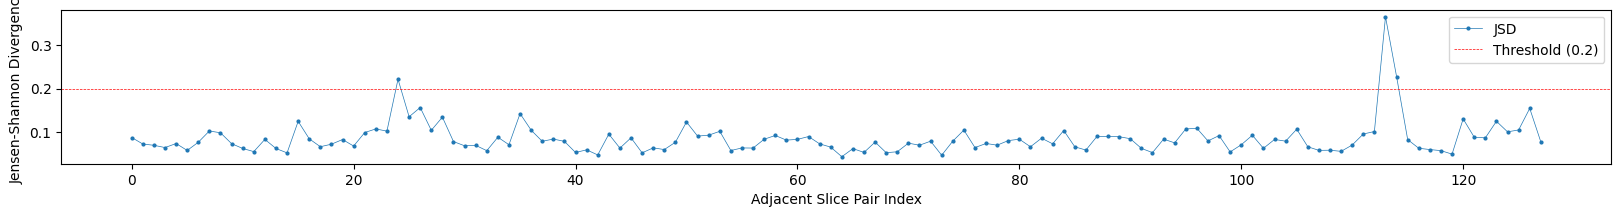

In [14]:
sec_cluster_df = pd.DataFrame(0, index=[str(i) for i in range(len(adata_alpha1.obs['clusters'].unique()))], columns=sorted(adata_alpha1.obs['section'].unique()))
for sec in sorted(adata_alpha1.obs['section'].unique()):
    adata_s = adata_alpha1[adata_alpha1.obs['section'] == sec]
    cluster_counts = adata_s.obs['clusters'].value_counts()
    for cluster, count in cluster_counts.items():
        sec_cluster_df.loc[cluster, sec] = count


sec_cluster_df_proportions = sec_cluster_df.div(sec_cluster_df.sum(axis=0), axis=1)
sec_cluster_df_proportions = sec_cluster_df_proportions.iloc[:, ::-1]
sec_cluster_df_proportions = sec_cluster_df_proportions.dropna()


from scipy.spatial.distance import jensenshannon

jsd_diff = []
for i in range(len(sec_cluster_df_proportions.columns) - 1):
    slice1 = sec_cluster_df_proportions.columns[i]
    slice2 = sec_cluster_df_proportions.columns[i+1]
    
    p = sec_cluster_df_proportions.iloc[:, i].values.astype(float)
    q = sec_cluster_df_proportions.iloc[:, i+1].values.astype(float)
    jsd = jensenshannon(p, q)
    jsd_diff.append(jsd)

plt.figure(figsize=(20,2))
line, = plt.plot(jsd_diff, marker='o', linestyle='-', label='JSD', lw=0.5, ms=2)

plt.axhline(0.2, color='red', linestyle='--', label='Threshold (0.2)', lw=0.5)
plt.xlabel('Adjacent Slice Pair Index')
plt.ylabel('Jensen-Shannon Divergence')
plt.legend()

**alpha = 0**

The clustering results have been saved in ./results/mouse_1/2025_07_23_20_37_12/feature_add_weight0/Clusters_res0.75/
AnnData object with n_obs × n_vars = 250535 × 1122
    obs: 'x_section_mean', 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id', 'clusters'
    uns: 'log1p', 'neighbors', 'umap', 'clusters', 'clusters_colors'
    obsm: 'feature_spa', 'feature_con', 'feature_add', 'X_umap'
    obsp: 'distances', 'connectivities'


100%|██████████| 25/25 [02:12<00:00,  5.29s/it]


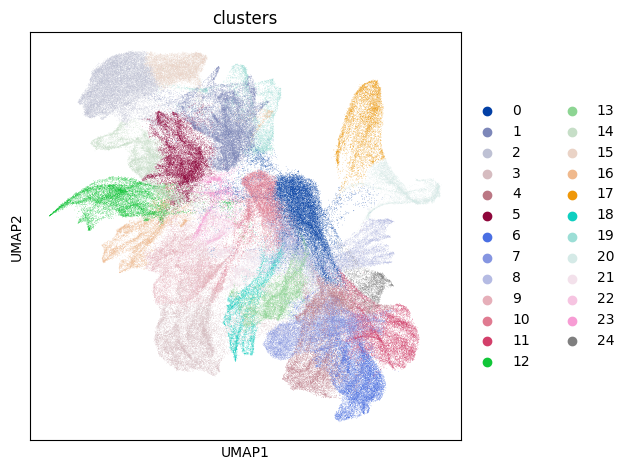

In [ ]:
adata_alpha0, path = clustering(adata, alpha=0, adata_save_path=results_save_path, cluster_resolution=0.75)

plot_all_results(adata_alpha0, path, figsize, plot_x, plot_y)

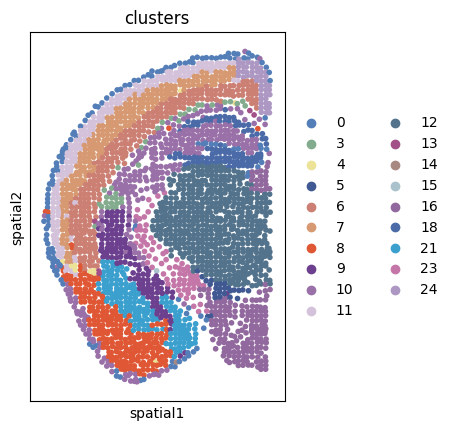

In [16]:
# 2D result plot

adata_alpha0.obsm['spatial'] = adata_alpha0.obs[['z', 'y']].values
adata_alpha0.obs.index = adata_alpha0.obs.index.astype(str)
adata_s = adata_alpha0[adata_alpha0.obs['section'] == 'Zhuang-ABCA-1.081']
adata_s = adata_s[adata_s.obs['z'] < 56]   # Removal of part of the right brain
sc.pl.spatial(adata_s, color='clusters', spot_size=1.25, show=True, palette=cluster_color)

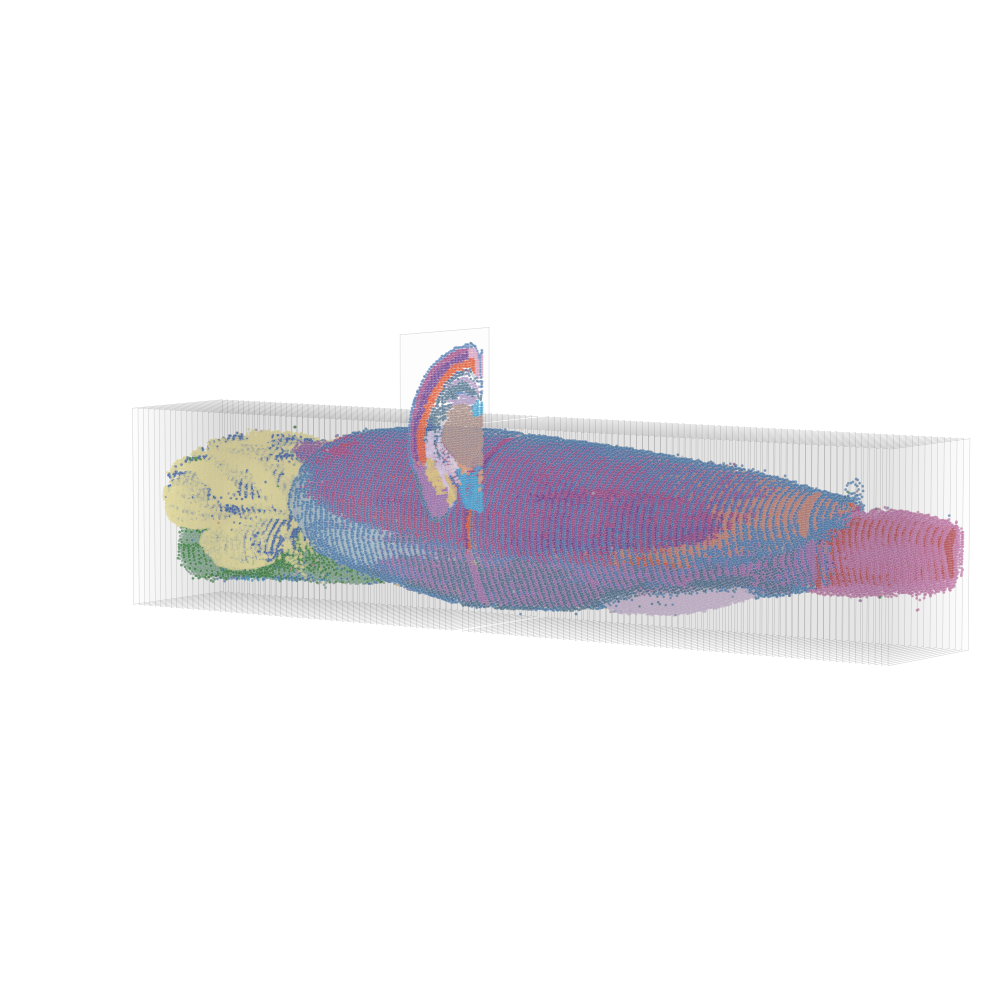

In [42]:
# 3D result plot
result_plot_3D(adata_alpha0, highlight_section='Zhuang-ABCA-1.081', cluster_color=cluster_color)

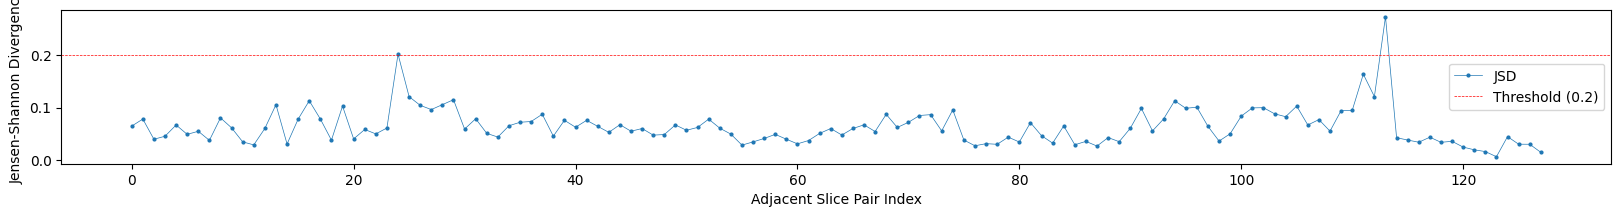

In [18]:
sec_cluster_df = pd.DataFrame(0, index=[str(i) for i in range(len(adata_alpha0.obs['clusters'].unique()))], columns=sorted(adata_alpha0.obs['section'].unique()))
for sec in sorted(adata_alpha0.obs['section'].unique()):
    adata_s = adata_alpha0[adata_alpha0.obs['section'] == sec]
    cluster_counts = adata_s.obs['clusters'].value_counts()
    for cluster, count in cluster_counts.items():
        sec_cluster_df.loc[cluster, sec] = count


sec_cluster_df_proportions = sec_cluster_df.div(sec_cluster_df.sum(axis=0), axis=1)
sec_cluster_df_proportions = sec_cluster_df_proportions.iloc[:, ::-1]
sec_cluster_df_proportions = sec_cluster_df_proportions.dropna()


from scipy.spatial.distance import jensenshannon

jsd_diff = []
for i in range(len(sec_cluster_df_proportions.columns) - 1):
    slice1 = sec_cluster_df_proportions.columns[i]
    slice2 = sec_cluster_df_proportions.columns[i+1]
    
    p = sec_cluster_df_proportions.iloc[:, i].values.astype(float)
    q = sec_cluster_df_proportions.iloc[:, i+1].values.astype(float)
    jsd = jensenshannon(p, q)
    jsd_diff.append(jsd)

plt.figure(figsize=(20,2))
line, = plt.plot(jsd_diff, marker='o', linestyle='-', label='JSD', lw=0.5, ms=2)

plt.axhline(0.2, color='red', linestyle='--', label='Threshold (0.2)', lw=0.5)
plt.xlabel('Adjacent Slice Pair Index')
plt.ylabel('Jensen-Shannon Divergence')
plt.legend()